In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import TidalPy
TidalPy.clear_cache(verbose=False)

from TidalPy.toolbox.conversions import days2rads, rads2days, semi_a2orbital_motion
from TidalPy.rheology.complex_compliance.compliance_models import maxwell, sundberg, andrade
from TidalPy.tides.multilayer.numerical_int import tidal_y_solver, tidal_y_solver_numba
from TidalPy.utilities.graphics.multilayer import yplot

R_Venus = 6050.0e3
M_Venus = 4.867e24
planet_bulk_density = M_Venus / ((4. / 3.) * np.pi * R_Venus**3)
venus_solar_day_freq = days2rads(116.75)
solar_day_forcing_frequency = venus_solar_day_freq

# Build Domain
N = 40
# Start at a radius slightly larger than 0.
radius_array_baseline = np.linspace(10., R_Venus, N)

# Rheology Inputs
alpha_baseline, zeta_baseline, andrade_critical_freq_baseline = 0.3, 1., days2rads(10000.)
rheology_inputs_baseline = (alpha_baseline, zeta_baseline, andrade_critical_freq_baseline)

# Integration parameters
int_rtol_scale = 1.
int_atol_scale = .01
use_numba_integrator = True

# Incompressibility Check
incomp_bulk = 1.0e18

In [11]:
# Build function inputs
N = 100
radius_array = np.linspace(0.1, R_Venus, N)

data = pd.read_csv('venus_data.csv')
radius_array = data['rad'].to_numpy()
density_array = data['rho'].to_numpy()
pressure_array = data['P'].to_numpy()
temperature_array = data['T'].to_numpy()
velocity_p = data['Vp'].to_numpy()
velocity_s = data['Vs'].to_numpy()
viscosity_array = data['visco'].to_numpy()
gravity_array = data['g'].to_numpy()

# Calculate shear and bulk modulus
shear_array = velocity_s**2 * density_array
bulk_array = velocity_p**2 * density_array - (4. / 3.) * shear_array

# Make any corrections
bulk_array[bulk_array < 0.] = 0.
shear_array[shear_array < 0.] = 0.

# Find the cut off between the inner core (if present), outer core, and mantle -- based on the shear velocity
oc_index = velocity_s == 0.
oc_radii = radius_array[oc_index]
cmb_radius = oc_radii[-1]
icb_radius = oc_radii[0]
mantle_index = radius_array > cmb_radius
ic_index = radius_array < icb_radius

complex_shear = maxwell(venus_solar_day_freq, shear_array**(-1), viscosity_array)**(-1)

function_inputs = (
    'solid_liquid_solid', radius_array, complex_shear, bulk_array, density_array, gravity_array,
    venus_solar_day_freq,
    (True, False, True), (True, True, True), (ic_index, oc_index, mantle_index)
)

function_kwargs = {
    'order_l': 2,
    'solve_load_numbers': False,
    'nondimensionalize': True,
    'integrator': 'scipy',
    'integration_method': 'DOP853',
    'integration_rtol': 1.e-6,
    'integration_atol': 1.e-8,
    'planet_bulk_density': planet_bulk_density
}

function_kwargs_load = {**function_kwargs}
function_kwargs_load['solve_load_numbers'] = True

function_kwargs_jl = {
    'order_l': 2,
    'solve_load_numbers': False,
    'nondimensionalize': True,
    'integrator': 'julia',
    'integration_method': 'Tsit5',
    'integration_rtol': 1.e-6,
    'integration_atol': 1.e-8,
    'planet_bulk_density': planet_bulk_density
}

function_kwargs_nb = {
    'order_l': 2,
    'solve_load_numbers': False,
    'nondimensionalize': True,
    'integrator': 'numba',
    'integration_method': 'RK45',
    'integration_rtol': 1.e-8,
    'integration_atol': 1.e-10,
    'planet_bulk_density': planet_bulk_density
}

function_kwargs_cy = {
    'order_l': 2,
    'solve_load_numbers': False,
    'nondimensionalize': True,
    'integrator': 'cython',
    'integration_method': 'RK45',
    'integration_rtol': 1.e-6,
    'integration_atol': 1.e-8,
    'planet_bulk_density': planet_bulk_density
}


C:\Users\joepr\AppData\Local\Temp\ipykernel_7684\3425088158.py:31: RuntimeWarning: divide by zero encountered in reciprocal
  complex_shear = maxwell(venus_solar_day_freq, shear_array**(-1), viscosity_array)**(-1)


In [ ]:
tidal_y = tidal_y_solver(*function_inputs, **function_kwargs)

_ = yplot(tidal_y, radius_array)

In [ ]:
tidal_y, load_y = tidal_y_solver(*function_inputs, **function_kwargs_load)

_ = yplot([tidal_y, load_y], [radius_array, radius_array])

## Baseline

n:\joe documents\research\software\tidalpy\TidalPy\tides\multilayer\numerical_int\interfaces\solid_liquid.py:180: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'solid_layer_ys' of function 'dynamic_static'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\..\TidalPy\tides\multilayer\numerical_int\interfaces\solid_liquid.py", line 93:
@njit(cacheable=True)
def dynamic_static(
^

  return dynamic_static(solid_layer_ys, interface_gravity, liquid_density, G_to_use=G_to_use)
C:\ProgramData\Anaconda3\lib\site-packages\numba\core\ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'solid_layer_ys' of function 'both_static'.

For more information visit https://numba.readthedocs.io/en/stable/ref

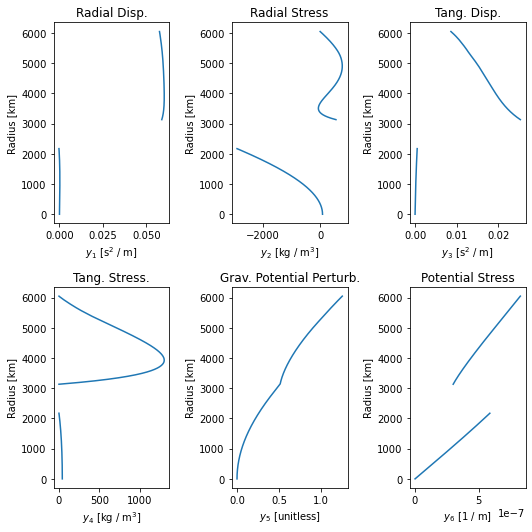

327 ms ± 845 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
# Scipy
# scipy RK45 - 95.6ms

tidal_y = tidal_y_solver(*function_inputs, **function_kwargs)

_ = yplot(tidal_y, radius_array)

%timeit tidal_y_solver(*function_inputs, **function_kwargs)

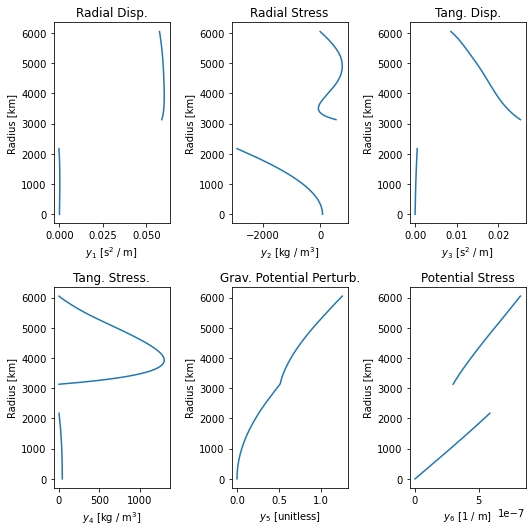

136 ms ± 333 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
# CyRK - Numba
# 10.2 ms

tidal_y = tidal_y_solver(*function_inputs, **function_kwargs_nb)

_ = yplot(tidal_y, radius_array)

%timeit tidal_y_solver(*function_inputs, **function_kwargs_nb)

In [ ]:
# CyRK - Cython
# RK45 = 12.4 s
# DOP853 = 
# RK23 = 

tidal_y = tidal_y_solver(*function_inputs, **function_kwargs_cy)

_ = yplot(tidal_y, radius_array)

# %timeit tidal_y_solver(*function_inputs, **function_kwargs_cy)

In [ ]:
# Julia
# RK45 = 897 ms
# Tsit5 = 171ms

tidal_y = tidal_y_solver(*function_inputs, **function_kwargs_jl)

_ = yplot(tidal_y, radius_array)

%timeit tidal_y_solver(*function_inputs, **function_kwargs_jl)